In [114]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
  
from dataset import get_ogb_data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from torch_geometric.loader import NeighborLoader
from ogb.nodeproppred import Evaluator
from scipy import sparse
from mne.stats import permutation_cluster_1samp_test
from gnn_model import GNN
from predict import evaluate_test
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [115]:
DEEP_DEPTH = 16
SHALLOW_DEPTH = 2 
depths_list = [DEEP_DEPTH, SHALLOW_DEPTH]

In [116]:
d_name = 'arxiv'
data, split_idx, num_classes = get_ogb_data('arxiv')
evaluator = Evaluator(name=f'ogbn-{d_name}')

def load_model(model_type, depth, data, num_classes):
    
    max_depth = 2 if depth == 'shallow' else 16
    
    if model_type=='SAGE':
        model = GNN(SAGEConv, data.x.shape[1], data.x.shape[1], num_classes, n_layers=max_depth)
    elif model_type=='GCN':
        model = GNN(GCNConv, data.x.shape[1], data.x.shape[1], num_classes, n_layers=max_depth)
    elif model_type=='GAT':
        model = GNN(GATConv, data.x.shape[1], data.x.shape[1], num_classes, n_layers=max_depth)

    model_dir = f'{depth}_{model_type}'
    best_pth_fn = os.path.join(model_dir,'model_best.pth')
    if os.path.exists(best_pth_fn):
        checkpoint = torch.load(best_pth_fn)
        model.load_state_dict(checkpoint['network_state_dict'], strict=False)
        print(f'{depth}_{model_type} loaded')
    return model

def load_test_loader(data, test_idx):
    test_loader = NeighborLoader(data, input_nodes=test_idx, num_neighbors=[-1],
                                    batch_size=128, shuffle=True)
    print('Test loader loaded')
    return test_loader

Number of nodes in the graph: 169343
Number of edges in the graph: 1166243
Number of training nodes: 90941
Number of validation nodes: 29799
Number of test nodes: 48603
Node feature matrix with shape: torch.Size([169343, 128])
Graph connectivity in COO format with shape: torch.Size([2, 1166243])
Target to train against : torch.Size([169343, 1])
Node feature length 128
number of target categories: 40


In [117]:
model_types = ['SAGE','GAT', 'GCN']
depth_types = ['shallow', 'deep']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_idx = split_idx['test']
num_permutations = 1000

In [32]:
for model_type in model_types:
    for depth_type in depth_types:
        model = load_model(model_type, depth_type, data, num_classes)
        model.to(device)
        test_loader = load_test_loader(data, test_idx)

        nods_results_depths_dict = {}
        ids_col = {'id': test_idx}
        id_depths_df = pd.DataFrame(data=ids_col)
        id_results_df = pd.DataFrame(data=ids_col)

        for perm in tqdm(range(num_permutations)):
            test_acc, inference_depths, ids, correctness = evaluate_test(model, test_loader, evaluator, data, depths_list, device)
            
            temp_df = pd.DataFrame(data={'id': ids, f'depth_{perm}': inference_depths})
            temp_df.sort_values(by=['id'], inplace=True)
            id_depths_df = id_depths_df.merge(temp_df, on='id')
            
            temp_df = pd.DataFrame(data={'id': ids, f'correctness_{perm}': correctness})
            temp_df.sort_values(by=['id'], inplace=True)
            id_results_df = id_results_df.merge(temp_df, on = 'id')
            
        sorted_ids = ids_col['id'].tolist()
        all_correctnesses = list(id_results_df.drop(['id'], axis=1).to_numpy().flatten())
        all_depths = list(id_depths_df.drop(['id'], axis=1).to_numpy().flatten())
        all_sorted_ids = list(np.repeat(sorted_ids, num_permutations))
        all_results_df = pd.DataFrame(data={'id': all_sorted_ids, 'correctness': all_correctnesses, 'depth': all_depths})
        
        id_depths_df.to_csv(f'id_depths_{depth_type}_{model_type}.csv', index=False)
        id_results_df.to_csv(f'id_results_{depth_type}_{model_type}.csv', index=False)
        all_results_df.to_csv(f'all_results_{depth_type}_{model_type}.csv', index=False)

shallow_GAT loaded
Test loader loaded


100%|██████████| 1000/1000 [22:06<00:00,  1.33s/it]


deep_GAT loaded
Test loader loaded


100%|██████████| 1000/1000 [58:19<00:00,  3.50s/it]


both_GAT loaded
Test loader loaded


100%|██████████| 1000/1000 [58:26<00:00,  3.51s/it]


shallow_GCN loaded
Test loader loaded


100%|██████████| 1000/1000 [16:42<00:00,  1.00s/it]


deep_GCN loaded
Test loader loaded


100%|██████████| 1000/1000 [32:27<00:00,  1.95s/it]


both_GCN loaded
Test loader loaded


100%|██████████| 1000/1000 [32:26<00:00,  1.95s/it]


## Build test adjacency matrix

In [118]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def edge_indx_to_adj(edge_index, num_nodes):
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

# filter indexes of matrix
def filter_indexes(adj, indexes):
    return adj[indexes][:,indexes]

test_idx = split_idx['test']
test_adj = filter_indexes(edge_indx_to_adj(data.edge_index, data.x.shape[0]), test_idx)

# convert test_adj to scipy sparse matrix
test_adj_sparse = test_adj.to_sparse()

In [21]:
def decide(pvalue):
    if pvalue < 0.05:
        return 'decided'
    else:
        return 'undecided'
    
def categorize(means, calssification):
    if calssification != 'decided':
        return 'undecided'
    elif means > 0:
        return 'shallow'
    else:
        return 'deep'

## Permutation test

In [ ]:
s_test_adj = sparse.csr_matrix(test_adj)
ids_to_pvalue_df_dict = {}
X = []
Y = []
model_types = ['GCN', 'GAT', 'SAGE']
results_folder = 'preliminary results'
for model_type in model_types:
    X = []
    Y = []  
    print(f'{model_type}')
    all_results_df = pd.read_csv(os.path.join(results_folder, f'all_results_both_{model_type}.csv'))
    ids_to_pvalue = {}
    for id in tqdm(np.array(test_idx)):
        id_df = all_results_df[all_results_df['id'] == id].copy()
        x = np.array(id_df[id_df['depth'] == 2]['correctness'])
        y = np.array(id_df[id_df['depth'] == 16]['correctness'])
        X.append(x)
        Y.append(y)
    min_len = np.min([len(x) for x in X])
    X_trancuated = [x[:min_len] for x in X]
    Y_trancuated = [y[:min_len] for y in Y]
    X_np = np.array(X_trancuated).transpose()
    Y_np = np.array(Y_trancuated).transpose()
    
    threshold = dict(start=0, step=0.2)
    t, _, p, h0 = permutation_cluster_1samp_test(X_np-Y_np, n_permutations=1024, threshold=threshold, tail=0, n_jobs=-1, adjacency=s_test_adj, verbose=False)
    
    df = pd.DataFrame(zip(*[test_idx.tolist(), list(p)]), columns=['id', 'pvalue'])
    df['decission'] = df.apply(lambda row: decide(row['pvalue']), axis=1)
    df['means'] = (X_np.mean(axis=0)-Y_np.mean(axis=0))
    df['vertex_class'] = df.apply(lambda row: categorize(row['means'], row['decission']), axis=1)
    df.to_csv(f'results/ids_to_pvalue_two_tailed_{model_type}.csv', index=False)
    ids_to_pvalue_df_dict[model_type] = df

[Text(0.5, 1.0, 'SAGE vertex classification')]

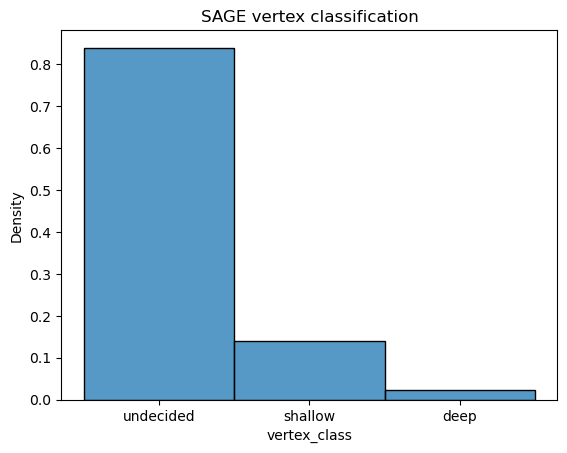

In [49]:
sns.histplot(ids_to_pvalue_df_dict['SAGE']['vertex_class'], discrete=True, stat="density").set(title='SAGE vertex classification')

[Text(0.5, 1.0, 'GCN vertex classification'),
 Text(0.5, 0, 'vertex class'),
 Text(0, 0.5, 'density')]

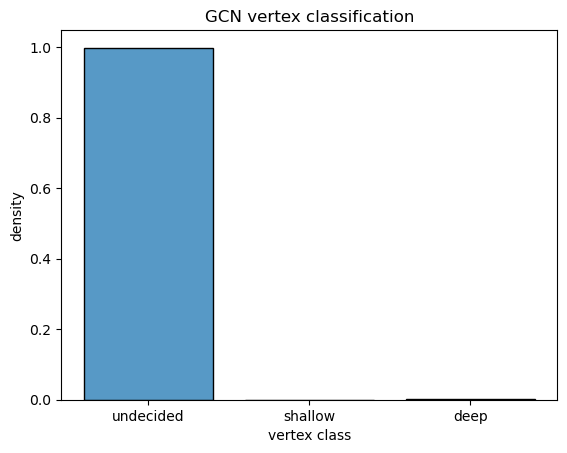

In [57]:
sns.histplot(ids_to_pvalue_df_dict['GCN']['vertex_class'], discrete=True, stat="density", shrink = 0.8).set(title='GCN vertex classification', xlabel='vertex class', ylabel='density')